### 1. Import the Required Libraries

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import random
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import wandb

### 2. Set Device

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 3. Data Loading and Processing

In [4]:
class KTHProcessedDataset(Dataset):
    def __init__(self, root_dir, sequence_length=15, transform=None):
        """
        root_dir: path of the parent directory that contains processed frames/images.
        sequence_length: the number of frames in each subsequence.
        transforms: augmentations applied to the frames (can be none or more).
        """
        self.root_dir = root_dir
        self.sequence_length = sequence_length
        self.transform = transform
        self.data = []
        self.class_mapping = {}

        # Parse through categories
        for label, category in enumerate(sorted(os.listdir(root_dir))):
            category_path = os.path.join(root_dir, category)
            # if not os.path.isdir(category_path):
            #     continue
            self.class_mapping[label] = category
            for subfolder in os.listdir(category_path):
                subfolder_path = os.path.join(category_path, subfolder)
                if os.path.isdir(subfolder_path): # check (folder also contain some json)
                    frames = sorted(os.listdir(subfolder_path))

                    # Create subsequences from frames
                    for start_idx in range(0, len(frames) - sequence_length + 1, sequence_length):  # (0, 450-15+1, 15)
                        subsequence_frames = frames[start_idx:start_idx + sequence_length]          # (0, 0+15), then (15, 30) and so on.
                        if len(subsequence_frames) == sequence_length:
                            self.data.append((subfolder_path, subsequence_frames, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        subfolder_path, frames, label = self.data[idx]

        sequence = []
        for frame_file in frames:
            frame_path = os.path.join(subfolder_path, frame_file)
            try:
                img = Image.open(frame_path).convert("L")
                if self.transform:
                    img = self.transform(img)

                img = img.view(-1)
                sequence.append(img)

            except Exception as e:
                # Found some corrupted image in the folders
                print(f"Skipping image {frame_path} due to error: {e}")
                return self.__getitem__((idx + 1) % len(self))

        # Stack frames into tensor
        sequence = torch.stack(sequence, dim=0)
        return sequence, label


- No image resizing is done because the processed frames are of size 64x64.
- Images are converted to Grayscale (64x64=4096 pixels) since it will save some computation time (and the images are also grayscale so we don't lose any information). For RGB the number of pixels will be 3 x 4096.

#### Define augmentations

In [5]:
# Define augmentations
transform = transforms.Compose([
    
    # RandomHorizontalFlip(p=0.5),
    # RandomRotation(degrees=15),
    transforms.RandomCrop(size=(64, 64), pad_if_needed=True),

    transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2)], p=0.3),
    transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
    
    transforms.ToTensor(),                             
    transforms.Normalize(mean=[0.5], std=[0.5])
])

Taking the sequence length because I observed that in some of the categories like jogging, the first 7-8 frames are empty and till the 40-45th frames we get a complete motion i.e. person comes in running in the frame and then goes out after that the frames are again empty till the person again comes from the opposite direction.

In [6]:
# Paths and hyperparameters
root_dir = '/home/nfs/inf6/data/datasets/kth_actions/processed'
sequence_length = 45
batch_size = 16
train_ratio = 0.8  # 80% for train 20% for val

In [7]:
# Load the whole dataset
dataset = KTHProcessedDataset(root_dir=root_dir, sequence_length=sequence_length, transform=transform)

# Calculate train and validation sizes
dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size

# Split dataset into train and val
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoaders for train and val sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Dataset size: {dataset_size}")
print(f"Train set size: {train_size}")
print(f"Validation set size: {val_size}")

Dataset size: 6150
Train set size: 4920
Validation set size: 1230


In [8]:
print("Dataset Classes:")
for class_id, class_name in dataset.class_mapping.items():
    print(f"Class ID: {class_id}, Class Name: {class_name}")

Dataset Classes:
Class ID: 0, Class Name: boxing
Class ID: 1, Class Name: handclapping
Class ID: 2, Class Name: handwaving
Class ID: 3, Class Name: jogging
Class ID: 4, Class Name: running
Class ID: 5, Class Name: walking


In [9]:
# reverse mapping of the dataclasses
reverse_mapping = {val:key for key,val in dataset.class_mapping.items()}
reverse_mapping

{'boxing': 0,
 'handclapping': 1,
 'handwaving': 2,
 'jogging': 3,
 'running': 4,
 'walking': 5}

#### Visualize dataset

In [9]:
def visualize_sequences(dataset, category_label, num_sequences=3, sequence_length=15):
    """
    Visualizes the first `num_sequences` sequences for a specific category label.
    
    Args:
        dataset: Instance of KTHProcessedDataset.
        category_label: Label of the category to visualize.
        num_sequences: Number of sequences to visualize.
        sequence_length: Length of each sequence.
    """
    sequences_shown = 0
    
    plt.figure(figsize=(15, num_sequences * 3))
    for i in range(len(dataset)):
        sequence, label = dataset[i]
        if label == category_label:
            for frame_idx in range(sequence_length):
                plt.subplot(num_sequences, sequence_length, sequences_shown * sequence_length + frame_idx + 1)
                frame = sequence[frame_idx].view(64, 64).cpu().numpy()
                plt.imshow(frame, cmap="gray")
                plt.axis("off")
            
            sequences_shown += 1
            if sequences_shown >= num_sequences:
                break

    plt.suptitle(f"Sequences for category label: {category_label}", fontsize=16)
    plt.show()

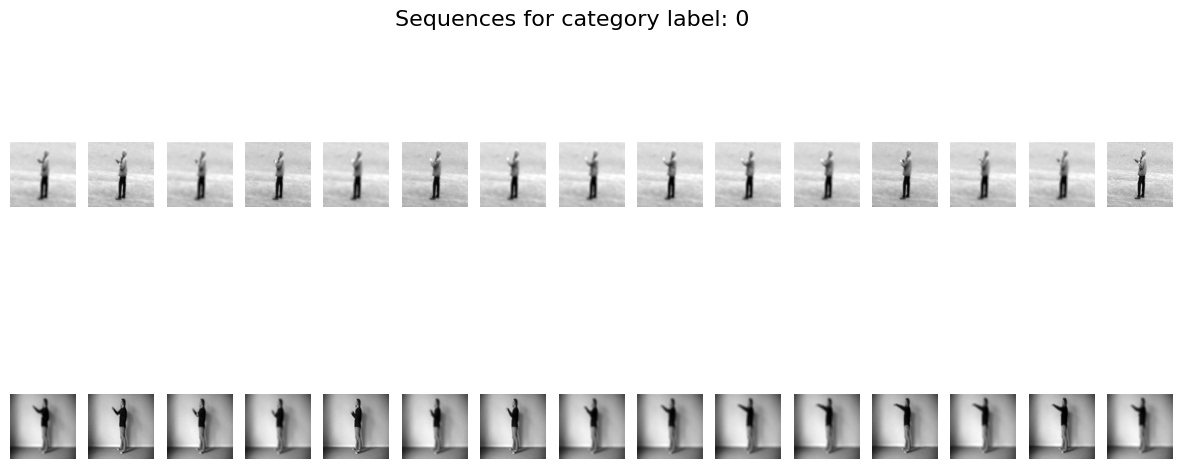

In [10]:
# Visualize sequences for category label 0 (e.g., walking)
category_name = 'boxing'
visualize_sequences(val_dataset, category_label=reverse_mapping[category_name], num_sequences=2, sequence_length=15)

### Training and Validation Code

This is the same code as used in the previous assignments with minor changes and integration of 'Weigths and Biases' for logging of metrics.

In [11]:
def train_nn(model, train_loader, criterion, optimizer, device):
    """Train  model for one epoch"""
    model.train()
    running_loss = 0.0
    correct_labels = 0
    total_labels = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Compute accuracy
        _, predicted_labels = torch.max(outputs, dim=1)
        correct_labels += (predicted_labels == labels).sum().item()
        total_labels += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = correct_labels / total_labels
    return avg_loss, accuracy

def evaluate_nn(model, eval_loader, criterion, device):
    """Evaluate the model after each epoch."""
    model.eval()
    running_loss = 0.0
    correct_labels = 0
    total_labels = 0

    with torch.no_grad():
        for inputs, labels in eval_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Compute accuracy
            _, predicted_labels = torch.max(outputs, dim=1)
            correct_labels += (predicted_labels == labels).sum().item()
            total_labels += labels.size(0)

    avg_loss = running_loss / len(eval_loader)
    accuracy = correct_labels / total_labels
    return avg_loss, accuracy

def run_training(model, train_loader, eval_loader, criterion, device, num_epochs, learning_rate=0.001, step_size=5, gamma=0.5,
                 project='lstm_training', name='test_run'):
    """Train and evaluate the model for a given number of epochs with W&B logging"""

    # Initialize W&B logging
    wandb.init(project=project, name=name, config={
        "learning_rate": learning_rate,
        "num_epochs": num_epochs,
        "step_size": step_size,
        "gamma": gamma,
        "optimizer": "Adam",
    },
    )
    config = wandb.config

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Optimizer
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)  # Learning rate scheduler
    
    train_losses = []
    eval_losses = []
    train_accuracies = []
    eval_accuracies = []
    learning_rates = []

    for epoch in tqdm(range(num_epochs)):
        # Train for one epoch
        train_loss, train_accuracy = train_nn(model, train_loader, criterion, optimizer, device)
        # Evaluate after each epoch
        eval_loss, eval_accuracy = evaluate_nn(model, eval_loader, criterion, device)

        current_lr = scheduler.get_last_lr()[0]


        train_losses.append(train_loss)
        eval_losses.append(eval_loss)
        train_accuracies.append(train_accuracy)
        eval_accuracies.append(eval_accuracy)
        learning_rates.append(current_lr)

        # Log metrics to W&B
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_accuracy,
            "eval_loss": eval_loss,
            "eval_accuracy": eval_accuracy,
            "learning_rate": current_lr
        })

        # Print stats after each epoch
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Eval Loss: {eval_loss:.4f}, Eval Accuracy: {eval_accuracy:.4f}")
        print(f"Learning Rate: {current_lr:.6f}")
        
        # Step the LR scheduler
        scheduler.step()

    # End W&B run
    wandb.finish()

    return model, train_losses, train_accuracies, eval_losses, eval_accuracies, learning_rates

### Result Visualization

In [10]:
def plot_confusion_matrix(y_true, y_pred, label_names, model_name):
    """
    Plots confusion matrix for a given model.

    Args:
        y_true (numpy.ndarray): True labels.
        y_pred (numpy.ndarray): Predicted labels.
        label_names (list): List of class names.
        model_name (str): The name of the model to display in the plot title.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_names, yticklabels=label_names, linewidths=1)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [11]:
# Function to evaluate model and compute predictions
def evaluate_model(model, dataloader, device="cuda"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for sequences, labels in dataloader:
            sequences = sequences.to(device)
            labels = labels.to(device)

            outputs = model(sequences)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

#### LSTM  and LSTM Cell from Scratch

Inspired from 
1. https://github.com/hadi-gharibi/pytorch-lstm/blob/master/lstm.ipynb
2. https://github.com/georgeyiasemis/Recurrent-Neural-Networks-from-scratch-using-PyTorch

both sources have highly similar code

In [15]:
### This works

class LSTMCell(nn.Module):
    """
    Custom LSTM Cell implementation from scratch
    
    Args:
    - input_size: Number of input features
    - hidden_size: Number of hidden units
    """
    def __init__(self, input_size, hidden_size):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # all gates weight combined into signle matrix
        # ih -> input_hidden
        # hh -> hidden_hidden
        self.weight_ih = nn.Parameter(torch.empty(4 * hidden_size, input_size))  
        self.weight_hh = nn.Parameter(torch.empty(4 * hidden_size, hidden_size))
        
        # Bias term
        self.bias_ih = nn.Parameter(torch.empty(4 * hidden_size))
        self.bias_hh = nn.Parameter(torch.empty(4 * hidden_size))
        
        # Initialize weights
        std = 1.0 / np.sqrt(self.hidden_size)
        nn.init.uniform_(self.weight_ih, -std, std)
        nn.init.uniform_(self.weight_hh, -std, std)
        nn.init.uniform_(self.bias_ih, -std, std)
        nn.init.uniform_(self.bias_hh, -std, std)
    
    def forward(self, x, hidden_state=None):
        """
        Forward pass for LSTM Cell
        
        Args:
        - x: input tensor of shape (batch_size, input_size)
        - hidden_state: tuple of (h, c) - previous hidden and cell states
        
        Returns:
        - new_h: new hidden state
        - new_c: new cell state
        """
        # Initialize hidden state if not provided
        if hidden_state is None:
            batch_size = x.size(0)
            h = x.new_zeros(batch_size, self.hidden_size)
            c = x.new_zeros(batch_size, self.hidden_size)
        else:
            h, c = hidden_state
        
        # Compute gate inputs
        gates = F.linear(x, self.weight_ih, self.bias_ih) + F.linear(h, self.weight_hh, self.bias_hh)
        
        # Split gates into 4 equal parts
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)
        
        # Apply activation
        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)
        
        # new cell state
        new_c = (forgetgate * c) + (ingate * cellgate)
        
        # new hidden state
        new_h = outgate * torch.tanh(new_c)
        
        return new_h, new_c

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, batch_first=True):
        super(LSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        
        # Create LSTM cells for each layer
        self.lstm_cells = nn.ModuleList()
        for i in range(num_layers):
            layer_input_size = input_size if i == 0 else hidden_size
            self.lstm_cells.append(LSTMCell(layer_input_size, hidden_size))
        
        # Classification layer
        self.classifier = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        if not self.batch_first:
            x = x.transpose(0, 1)
        
        batch_size, seq_len, _ = x.size()
        
        # Initialize hidden states
        h_list = []
        c_list = []
        for _ in range(self.num_layers):
            h_list.append(torch.zeros(batch_size, self.hidden_size, device=x.device))
            c_list.append(torch.zeros(batch_size, self.hidden_size, device=x.device))


        all_h_states = []

        for t in range(seq_len):
            # Current input at time  t
            input_t = x[:, t, :]
            
            for layer in range(self.num_layers):
                cell = self.lstm_cells[layer]
                
                # Use previous layer hidden state as input
                h_prev = input_t if layer == 0 else h_list[layer-1]
                
                # Update hidden and cell states
                h_list[layer], c_list[layer] = cell(h_prev, (h_list[layer], c_list[layer]))
            
            
            all_h_states.append(h_list[-1])

        # Stack the hidden states for all time steps
        all_h_states = torch.stack(all_h_states, dim=1)  # Shape: [batch_size, seq_len, hidden_size]

        
        output = self.classifier(all_h_states)

        return output


### Pytorch LSTM Model

In [16]:
class CustomPLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(CustomPLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Create LSTM cells for each layer
        self.lstm_cells = nn.ModuleList([
            nn.LSTMCell(input_size if i == 0 else hidden_size, hidden_size) 
            for i in range(num_layers)
        ])
        
        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        """
        Args:
            x: Input tensor of shape (batch_size, seq_len, input_size)
        Returns:
            output: Output tensor of shape (batch_size, seq_len, output_size)
        """
        batch_size, seq_len, _ = x.size()
        
        # Initialize hidden and cell states for each layer
        h_t = [torch.zeros(batch_size, self.hidden_size).to(x.device) for _ in range(self.num_layers)]
        c_t = [torch.zeros(batch_size, self.hidden_size).to(x.device) for _ in range(self.num_layers)]
        
        # To store the output at each time step
        outputs = []
        
        for t in range(seq_len):
            # Extract the time step t input
            x_t = x[:, t, :]
            
            # Pass through each layer
            for layer in range(self.num_layers):
                h_t[layer], c_t[layer] = self.lstm_cells[layer](
                    x_t, (h_t[layer], c_t[layer])
                )
                # The input to the next layer is the output of the current layer
                x_t = h_t[layer]
            
            # Pass the final layer's output through the fully connected layer
            output_t = self.fc(h_t[-1])
            outputs.append(output_t)
        
        # Stack the outputs to form the final output tensor
        outputs = torch.stack(outputs, dim=1)
        return outputs

In [17]:
class CustomGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(CustomGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.gru_cells = nn.ModuleList([
            nn.GRUCell(input_size if i == 0 else hidden_size, hidden_size)
            for i in range(num_layers)
        ])
        
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        
        # Initialize hidden states for each layer
        h_t = [torch.zeros(batch_size, self.hidden_size).to(x.device) for _ in range(self.num_layers)]
        
        outputs = []
        
        for t in range(seq_len):
            x_t = x[:, t, :]
            
            # Pass through each layer
            for layer in range(self.num_layers):
                h_t[layer] = self.gru_cells[layer](x_t, h_t[layer])
                x_t = h_t[layer]
            
            output_t = self.fc(h_t[-1])
            outputs.append(output_t)
        
        # Stack the outputs to form the final output tensor
        outputs = torch.stack(outputs, dim=1)
        return outputs

In [18]:
class ActionClassificationModel(nn.Module):
    def __init__(self, sequence_length, input_dim=64*64, num_classes=6, rnn_module='scratch_lstm'):
        super(ActionClassificationModel, self).__init__()
        self.sequence_length = sequence_length

        # Encoder Block
        self.encoder = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.4),
        )

        # RNN modules to be put here
        if rnn_module == 'scratch_lstm':
            # Custom LSTM Module
            self.rnn = LSTM(
                input_size=256 * 8 * 8,
                hidden_size=256,         
                num_layers=2,           
                num_classes=256,    
                batch_first=True
            )
        elif rnn_module == 'custom_lstm':
            self.rnn = CustomPLSTM(
            input_size=256 * 8 * 8,  # Flattened size from encoder
            hidden_size=256,         # Hidden state size
            output_size=256,         # Output size per time step
            num_layers=2             # Number of LSTM layers
            )

        elif rnn_module == 'gru':
            self.rnn = CustomGRU(
            input_size=256 * 8 * 8,  # Flattened size from encoder
            hidden_size=256,
            output_size=256,
            num_layers=2
            )

        else:
            print("Error")


        # Classifier
        self.classifier = nn.Sequential(
            nn.Conv1d(256, 128, kernel_size=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        
        # Reshape each frame
        x = x.view(batch_size * seq_len, 1, 64, 64)
        x = self.encoder(x)
        x = x.view(batch_size, seq_len, -1)
        
        # Recurrent Module
        x = self.rnn(x)  
        
        # print("Debug:", x.shape)
        
        # Classifier
        x = x.transpose(1, 2)
        x = self.classifier(x)
        
        return x

### LSTM from Scratch training

In [18]:
# Hyper parameters for LSTM
input_size = 64*64  # flattened size of frame
hidden_size = 256  # Hidden size of the LSTM
num_classes = len(os.listdir("/home/nfs/inf6/data/datasets/kth_actions/processed"))  # Number of output classes
num_layers = 2

# Hyperparameters for training
num_epochs = 30
learning_rate = 0.001  # Initial learning rate
step_size = 5          # To be used in LR Scheduler
gamma = 0.5            # To be used in LR Scheduler
name = f"lstm_scratch_ep_{num_epochs}_lr_{learning_rate}"
project = 'assignment_4'

#criterion
criterion = nn.CrossEntropyLoss()

In [19]:
model = ActionClassificationModel(input_dim=input_size, 
                                           sequence_length=sequence_length, 
                                           num_classes=num_classes).to(device)
model

ActionClassificationModel(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.3, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dr

In [20]:
# Run training
model, train_losses, train_accuracies, eval_losses, eval_accuracies, learning_rates = run_training(
    model, 
    train_loader, val_loader, 
    criterion,
    device,
    num_epochs=num_epochs, 
    learning_rate=learning_rate, 
    step_size=step_size, 
    gamma=gamma,
    name=name, project=project
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /home/user/javeda1/.netrc


  3%|█▊                                                     | 1/30 [02:03<59:49, 123.77s/it]

Epoch 1/30
Train Loss: 1.1827, Train Accuracy: 0.3738
Eval Loss: 1.0765, Eval Accuracy: 0.4569
Learning Rate: 0.001000


  7%|███▋                                                   | 2/30 [03:49<52:54, 113.39s/it]

Epoch 2/30
Train Loss: 1.0397, Train Accuracy: 0.4602
Eval Loss: 0.9790, Eval Accuracy: 0.4780
Learning Rate: 0.001000


 10%|█████▌                                                 | 3/30 [05:35<49:19, 109.61s/it]

Epoch 3/30
Train Loss: 0.8865, Train Accuracy: 0.5612
Eval Loss: 0.8290, Eval Accuracy: 0.6049
Learning Rate: 0.001000


 13%|███████▎                                               | 4/30 [07:21<47:00, 108.47s/it]

Epoch 4/30
Train Loss: 0.7690, Train Accuracy: 0.6240
Eval Loss: 0.7335, Eval Accuracy: 0.6236
Learning Rate: 0.001000


 17%|█████████▏                                             | 5/30 [09:06<44:39, 107.19s/it]

Epoch 5/30
Train Loss: 0.6772, Train Accuracy: 0.7108
Eval Loss: 0.6246, Eval Accuracy: 0.7033
Learning Rate: 0.001000


 20%|███████████                                            | 6/30 [10:51<42:33, 106.39s/it]

Epoch 6/30
Train Loss: 0.5160, Train Accuracy: 0.7703
Eval Loss: 0.5887, Eval Accuracy: 0.7398
Learning Rate: 0.000500


 23%|████████████▊                                          | 7/30 [12:35<40:26, 105.50s/it]

Epoch 7/30
Train Loss: 0.4686, Train Accuracy: 0.7898
Eval Loss: 0.5542, Eval Accuracy: 0.7715
Learning Rate: 0.000500


 27%|██████████████▋                                        | 8/30 [14:18<38:27, 104.91s/it]

Epoch 8/30
Train Loss: 0.4388, Train Accuracy: 0.8008
Eval Loss: 0.5656, Eval Accuracy: 0.7618
Learning Rate: 0.000500


 30%|████████████████▌                                      | 9/30 [16:04<36:45, 105.04s/it]

Epoch 9/30
Train Loss: 0.4088, Train Accuracy: 0.8148
Eval Loss: 0.4534, Eval Accuracy: 0.7943
Learning Rate: 0.000500


 33%|██████████████████                                    | 10/30 [17:47<34:52, 104.63s/it]

Epoch 10/30
Train Loss: 0.3863, Train Accuracy: 0.8236
Eval Loss: 0.4777, Eval Accuracy: 0.7919
Learning Rate: 0.000500


 37%|███████████████████▊                                  | 11/30 [19:31<33:02, 104.34s/it]

Epoch 11/30
Train Loss: 0.3302, Train Accuracy: 0.8461
Eval Loss: 0.4124, Eval Accuracy: 0.8236
Learning Rate: 0.000250


 40%|█████████████████████▌                                | 12/30 [21:15<31:15, 104.20s/it]

Epoch 12/30
Train Loss: 0.3175, Train Accuracy: 0.8522
Eval Loss: 0.4052, Eval Accuracy: 0.8252
Learning Rate: 0.000250


 43%|███████████████████████▍                              | 13/30 [22:58<29:26, 103.91s/it]

Epoch 13/30
Train Loss: 0.3011, Train Accuracy: 0.8606
Eval Loss: 0.4450, Eval Accuracy: 0.8244
Learning Rate: 0.000250


 47%|█████████████████████████▏                            | 14/30 [24:42<27:40, 103.81s/it]

Epoch 14/30
Train Loss: 0.2861, Train Accuracy: 0.8654
Eval Loss: 0.4676, Eval Accuracy: 0.8106
Learning Rate: 0.000250


 50%|███████████████████████████                           | 15/30 [26:26<25:57, 103.85s/it]

Epoch 15/30
Train Loss: 0.2703, Train Accuracy: 0.8740
Eval Loss: 0.4346, Eval Accuracy: 0.8268
Learning Rate: 0.000250


 53%|████████████████████████████▊                         | 16/30 [28:09<24:11, 103.68s/it]

Epoch 16/30
Train Loss: 0.2586, Train Accuracy: 0.8811
Eval Loss: 0.4216, Eval Accuracy: 0.8398
Learning Rate: 0.000125


 57%|██████████████████████████████▌                       | 17/30 [29:52<22:26, 103.55s/it]

Epoch 17/30
Train Loss: 0.2425, Train Accuracy: 0.8874
Eval Loss: 0.4147, Eval Accuracy: 0.8431
Learning Rate: 0.000125


 60%|████████████████████████████████▍                     | 18/30 [31:36<20:43, 103.59s/it]

Epoch 18/30
Train Loss: 0.2386, Train Accuracy: 0.8868
Eval Loss: 0.4304, Eval Accuracy: 0.8382
Learning Rate: 0.000125


 63%|██████████████████████████████████▏                   | 19/30 [33:20<19:00, 103.72s/it]

Epoch 19/30
Train Loss: 0.2349, Train Accuracy: 0.8868
Eval Loss: 0.4063, Eval Accuracy: 0.8480
Learning Rate: 0.000125


 67%|████████████████████████████████████                  | 20/30 [35:04<17:18, 103.85s/it]

Epoch 20/30
Train Loss: 0.2286, Train Accuracy: 0.8927
Eval Loss: 0.4134, Eval Accuracy: 0.8463
Learning Rate: 0.000125


 70%|█████████████████████████████████████▊                | 21/30 [36:49<15:36, 104.09s/it]

Epoch 21/30
Train Loss: 0.2129, Train Accuracy: 0.8996
Eval Loss: 0.4144, Eval Accuracy: 0.8496
Learning Rate: 0.000063


 73%|███████████████████████████████████████▌              | 22/30 [38:33<13:52, 104.07s/it]

Epoch 22/30
Train Loss: 0.2083, Train Accuracy: 0.9016
Eval Loss: 0.4433, Eval Accuracy: 0.8455
Learning Rate: 0.000063


 77%|█████████████████████████████████████████▍            | 23/30 [40:17<12:09, 104.18s/it]

Epoch 23/30
Train Loss: 0.2033, Train Accuracy: 0.9055
Eval Loss: 0.4439, Eval Accuracy: 0.8463
Learning Rate: 0.000063


 80%|███████████████████████████████████████████▏          | 24/30 [42:01<10:24, 104.09s/it]

Epoch 24/30
Train Loss: 0.2040, Train Accuracy: 0.9033
Eval Loss: 0.4474, Eval Accuracy: 0.8463
Learning Rate: 0.000063


 83%|█████████████████████████████████████████████         | 25/30 [43:45<08:40, 104.15s/it]

Epoch 25/30
Train Loss: 0.1999, Train Accuracy: 0.9049
Eval Loss: 0.4557, Eval Accuracy: 0.8439
Learning Rate: 0.000063


 87%|██████████████████████████████████████████████▊       | 26/30 [45:30<06:57, 104.25s/it]

Epoch 26/30
Train Loss: 0.1934, Train Accuracy: 0.9065
Eval Loss: 0.4550, Eval Accuracy: 0.8488
Learning Rate: 0.000031


 90%|████████████████████████████████████████████████▌     | 27/30 [47:13<05:11, 103.98s/it]

Epoch 27/30
Train Loss: 0.1894, Train Accuracy: 0.9073
Eval Loss: 0.4591, Eval Accuracy: 0.8488
Learning Rate: 0.000031


 93%|██████████████████████████████████████████████████▍   | 28/30 [48:58<03:28, 104.10s/it]

Epoch 28/30
Train Loss: 0.1907, Train Accuracy: 0.9096
Eval Loss: 0.4639, Eval Accuracy: 0.8480
Learning Rate: 0.000031


 97%|████████████████████████████████████████████████████▏ | 29/30 [50:41<01:43, 103.89s/it]

Epoch 29/30
Train Loss: 0.1852, Train Accuracy: 0.9067
Eval Loss: 0.4603, Eval Accuracy: 0.8488
Learning Rate: 0.000031


100%|██████████████████████████████████████████████████████| 30/30 [52:25<00:00, 104.86s/it]

Epoch 30/30
Train Loss: 0.1855, Train Accuracy: 0.9083
Eval Loss: 0.4827, Eval Accuracy: 0.8463
Learning Rate: 0.000031


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
eval_accuracy,▁▁▄▄▅▆▇▆▇▇███▇████████████████
eval_loss,█▇▅▄▃▃▃▃▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂
learning_rate,█████▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▂▃▄▅▆▆▇▇▇▇▇▇▇████████████████
train_loss,█▇▆▅▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,30
eval_accuracy,0.84634
eval_loss,0.48274
learning_rate,3e-05
train_accuracy,0.90833


In [21]:
save_path = "./saved_models/lstm_scratch.pth"
torch.save(model, save_path)

In [19]:
def load_model(model_path):
    model = torch.load(model_path)
    return model

/tmp/ipykernel_1599014/2120265427.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


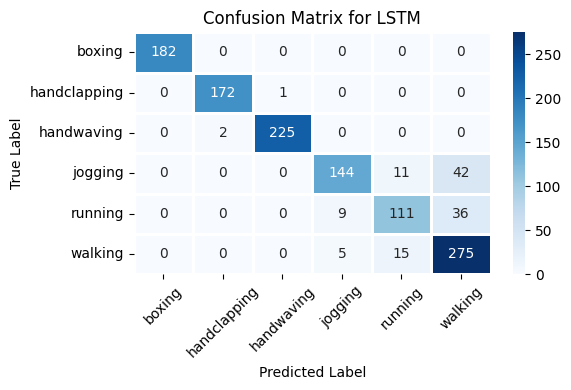

In [20]:
model = load_model("./saved_models/lstm_scratch.pth")
# Use the function to get results
y_true, y_pred = evaluate_model(model, val_loader)

# Class label names
label_names = ['boxing','handclapping', 'handwaving', 'jogging', 'running', 'walking']

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, label_names, model_name="LSTM")

#### Pytorch LSTM Training

In [22]:
# Hyper parameters for LSTM
input_size = 64*64  # flattened size of frame
hidden_size = 256  # Hidden size of the LSTM
num_classes = len(os.listdir("/home/nfs/inf6/data/datasets/kth_actions/processed"))  # Number of output classes
num_layers = 2

# Hyperparameters for training
num_epochs = 30
learning_rate = 0.001  # Initial learning rate
step_size = 5          # To be used in LR Scheduler
gamma = 0.5            # To be used in LR Scheduler
name = f"lstm_pytorch_ep_{num_epochs}_lr_{learning_rate}"
project = 'assignment_4'

#criterion
criterion = nn.CrossEntropyLoss()

In [23]:
model = ActionClassificationModel(input_dim=input_size, 
                                           sequence_length=sequence_length, 
                                           num_classes=num_classes,rnn_module='custom_lstm').to(device)
model

ActionClassificationModel(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.3, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dr

In [24]:
# Run training
model, train_losses, train_accuracies, eval_losses, eval_accuracies, learning_rates = run_training(
    model, 
    train_loader, val_loader, 
    criterion,
    device,
    num_epochs=num_epochs, 
    learning_rate=learning_rate, 
    step_size=step_size, 
    gamma=gamma,
    name=name, project=project
)

wandb: Currently logged in as: ahmadjaved97. Use `wandb login --relogin` to force relogin


  3%|█▊                                                     | 1/30 [01:44<50:18, 104.09s/it]

Epoch 1/30
Train Loss: 1.1636, Train Accuracy: 0.3945
Eval Loss: 1.0338, Eval Accuracy: 0.4699
Learning Rate: 0.001000


  7%|███▋                                                   | 2/30 [03:27<48:31, 103.97s/it]

Epoch 2/30
Train Loss: 0.9525, Train Accuracy: 0.5258
Eval Loss: 0.8318, Eval Accuracy: 0.5764
Learning Rate: 0.001000


 10%|█████▌                                                 | 3/30 [05:11<46:46, 103.96s/it]

Epoch 3/30
Train Loss: 0.7729, Train Accuracy: 0.6315
Eval Loss: 0.8423, Eval Accuracy: 0.6154
Learning Rate: 0.001000


 13%|███████▎                                               | 4/30 [06:56<45:09, 104.21s/it]

Epoch 4/30
Train Loss: 0.6677, Train Accuracy: 0.6715
Eval Loss: 0.6348, Eval Accuracy: 0.6715
Learning Rate: 0.001000


 17%|█████████▏                                             | 5/30 [08:39<43:16, 103.88s/it]

Epoch 5/30
Train Loss: 0.6073, Train Accuracy: 0.7061
Eval Loss: 0.5849, Eval Accuracy: 0.7260
Learning Rate: 0.001000


 20%|███████████                                            | 6/30 [10:24<41:42, 104.29s/it]

Epoch 6/30
Train Loss: 0.4645, Train Accuracy: 0.7896
Eval Loss: 0.4895, Eval Accuracy: 0.7919
Learning Rate: 0.000500


 23%|████████████▊                                          | 7/30 [12:10<40:07, 104.69s/it]

Epoch 7/30
Train Loss: 0.4074, Train Accuracy: 0.8142
Eval Loss: 0.4406, Eval Accuracy: 0.7984
Learning Rate: 0.000500


 27%|██████████████▋                                        | 8/30 [13:53<38:15, 104.33s/it]

Epoch 8/30
Train Loss: 0.3848, Train Accuracy: 0.8258
Eval Loss: 0.4338, Eval Accuracy: 0.8138
Learning Rate: 0.000500


 30%|████████████████▌                                      | 9/30 [15:39<36:35, 104.56s/it]

Epoch 9/30
Train Loss: 0.3483, Train Accuracy: 0.8429
Eval Loss: 0.4376, Eval Accuracy: 0.8114
Learning Rate: 0.000500


 33%|██████████████████                                    | 10/30 [17:23<34:51, 104.59s/it]

Epoch 10/30
Train Loss: 0.3399, Train Accuracy: 0.8435
Eval Loss: 0.4154, Eval Accuracy: 0.8179
Learning Rate: 0.000500


 37%|███████████████████▊                                  | 11/30 [19:06<32:58, 104.14s/it]

Epoch 11/30
Train Loss: 0.2948, Train Accuracy: 0.8659
Eval Loss: 0.4019, Eval Accuracy: 0.8268
Learning Rate: 0.000250


 40%|█████████████████████▌                                | 12/30 [20:49<31:07, 103.75s/it]

Epoch 12/30
Train Loss: 0.2807, Train Accuracy: 0.8703
Eval Loss: 0.4316, Eval Accuracy: 0.8268
Learning Rate: 0.000250


 43%|███████████████████████▍                              | 13/30 [22:34<29:29, 104.09s/it]

Epoch 13/30
Train Loss: 0.2738, Train Accuracy: 0.8734
Eval Loss: 0.4378, Eval Accuracy: 0.8228
Learning Rate: 0.000250


 47%|█████████████████████████▏                            | 14/30 [24:17<27:41, 103.85s/it]

Epoch 14/30
Train Loss: 0.2600, Train Accuracy: 0.8760
Eval Loss: 0.4243, Eval Accuracy: 0.8358
Learning Rate: 0.000250


 50%|███████████████████████████                           | 15/30 [26:02<25:59, 103.97s/it]

Epoch 15/30
Train Loss: 0.2621, Train Accuracy: 0.8742
Eval Loss: 0.4163, Eval Accuracy: 0.8341
Learning Rate: 0.000250


 53%|████████████████████████████▊                         | 16/30 [27:45<24:11, 103.69s/it]

Epoch 16/30
Train Loss: 0.2373, Train Accuracy: 0.8880
Eval Loss: 0.4225, Eval Accuracy: 0.8374
Learning Rate: 0.000125


 57%|██████████████████████████████▌                       | 17/30 [29:28<22:26, 103.60s/it]

Epoch 17/30
Train Loss: 0.2218, Train Accuracy: 0.8965
Eval Loss: 0.4301, Eval Accuracy: 0.8447
Learning Rate: 0.000125


 60%|████████████████████████████████▍                     | 18/30 [31:12<20:44, 103.73s/it]

Epoch 18/30
Train Loss: 0.2218, Train Accuracy: 0.8939
Eval Loss: 0.4161, Eval Accuracy: 0.8415
Learning Rate: 0.000125


 63%|██████████████████████████████████▏                   | 19/30 [32:56<19:01, 103.78s/it]

Epoch 19/30
Train Loss: 0.2130, Train Accuracy: 0.8986
Eval Loss: 0.4476, Eval Accuracy: 0.8358
Learning Rate: 0.000125


 67%|████████████████████████████████████                  | 20/30 [34:39<17:15, 103.51s/it]

Epoch 20/30
Train Loss: 0.2147, Train Accuracy: 0.8967
Eval Loss: 0.4315, Eval Accuracy: 0.8447
Learning Rate: 0.000125


 70%|█████████████████████████████████████▊                | 21/30 [36:22<15:31, 103.49s/it]

Epoch 21/30
Train Loss: 0.1962, Train Accuracy: 0.9085
Eval Loss: 0.4472, Eval Accuracy: 0.8463
Learning Rate: 0.000063


 73%|███████████████████████████████████████▌              | 22/30 [38:06<13:48, 103.54s/it]

Epoch 22/30
Train Loss: 0.1973, Train Accuracy: 0.9083
Eval Loss: 0.4523, Eval Accuracy: 0.8431
Learning Rate: 0.000063


 77%|█████████████████████████████████████████▍            | 23/30 [39:49<12:03, 103.37s/it]

Epoch 23/30
Train Loss: 0.1913, Train Accuracy: 0.9087
Eval Loss: 0.4638, Eval Accuracy: 0.8520
Learning Rate: 0.000063


 80%|███████████████████████████████████████████▏          | 24/30 [41:32<10:20, 103.39s/it]

Epoch 24/30
Train Loss: 0.1871, Train Accuracy: 0.9106
Eval Loss: 0.4712, Eval Accuracy: 0.8472
Learning Rate: 0.000063


 83%|█████████████████████████████████████████████         | 25/30 [43:17<08:39, 103.86s/it]

Epoch 25/30
Train Loss: 0.1894, Train Accuracy: 0.9120
Eval Loss: 0.4542, Eval Accuracy: 0.8504
Learning Rate: 0.000063


 87%|██████████████████████████████████████████████▊       | 26/30 [45:01<06:55, 103.91s/it]

Epoch 26/30
Train Loss: 0.1785, Train Accuracy: 0.9171
Eval Loss: 0.4660, Eval Accuracy: 0.8545
Learning Rate: 0.000031


 90%|████████████████████████████████████████████████▌     | 27/30 [46:45<05:11, 103.71s/it]

Epoch 27/30
Train Loss: 0.1782, Train Accuracy: 0.9152
Eval Loss: 0.4632, Eval Accuracy: 0.8545
Learning Rate: 0.000031


 93%|██████████████████████████████████████████████████▍   | 28/30 [48:29<03:27, 103.91s/it]

Epoch 28/30
Train Loss: 0.1750, Train Accuracy: 0.9181
Eval Loss: 0.4688, Eval Accuracy: 0.8569
Learning Rate: 0.000031


 97%|████████████████████████████████████████████████████▏ | 29/30 [50:12<01:43, 103.76s/it]

Epoch 29/30
Train Loss: 0.1732, Train Accuracy: 0.9179
Eval Loss: 0.4777, Eval Accuracy: 0.8593
Learning Rate: 0.000031


100%|██████████████████████████████████████████████████████| 30/30 [51:56<00:00, 103.89s/it]

Epoch 30/30
Train Loss: 0.1709, Train Accuracy: 0.9205
Eval Loss: 0.4730, Eval Accuracy: 0.8569
Learning Rate: 0.000031


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
eval_accuracy,▁▃▄▅▆▇▇▇▇▇▇▇▇█████████████████
eval_loss,█▆▆▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂▂▂▂▂▂▂▂▂
learning_rate,█████▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▃▄▅▅▆▇▇▇▇▇▇▇▇▇███████████████
train_loss,█▇▅▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,30
eval_accuracy,0.85691
eval_loss,0.473
learning_rate,3e-05
train_accuracy,0.92053


In [25]:
save_path = "./saved_models/pytorch_lstm.pth"
torch.save(model, save_path)

In [ ]:
model = load_model("./saved_models/pytorch_lstm.pth")
# Use the function to get results
y_true, y_pred = evaluate_model(model, val_loader)

# Class label names
label_names = ['boxing','handclapping', 'handwaving', 'jogging', 'running', 'walking']

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, label_names, model_name="LSTM")

/tmp/ipykernel_1599014/2120265427.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


### Pytorch GRU

In [27]:
# Hyper parameters for LSTM
input_size = 64*64  # flattened size of frame
hidden_size = 256  # Hidden size of the LSTM
num_classes = len(os.listdir("/home/nfs/inf6/data/datasets/kth_actions/processed"))  # Number of output classes
num_layers = 2

# Hyperparameters for training
num_epochs = 30
learning_rate = 0.001  # Initial learning rate
step_size = 5          # To be used in LR Scheduler
gamma = 0.5            # To be used in LR Scheduler
name = f"gru_pytorch_ep_{num_epochs}_lr_{learning_rate}"
project = 'assignment_4'

#criterion
criterion = nn.CrossEntropyLoss()

In [28]:
model = ActionClassificationModel(input_dim=input_size, 
                                           sequence_length=sequence_length, 
                                           num_classes=num_classes,rnn_module='gru').to(device)
model

ActionClassificationModel(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.3, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dr

In [29]:
# Run training
model, train_losses, train_accuracies, eval_losses, eval_accuracies, learning_rates = run_training(
    model, 
    train_loader, val_loader, 
    criterion,
    device,
    num_epochs=num_epochs, 
    learning_rate=learning_rate, 
    step_size=step_size, 
    gamma=gamma,
    name=name, project=project
)

  3%|█████▏                                                                                                                                                    | 1/30 [01:43<50:13, 103.92s/it]

Epoch 1/30
Train Loss: 1.0768, Train Accuracy: 0.4535
Eval Loss: 0.9280, Eval Accuracy: 0.5382
Learning Rate: 0.001000


  7%|██████████▎                                                                                                                                               | 2/30 [03:26<48:12, 103.30s/it]

Epoch 2/30
Train Loss: 0.8000, Train Accuracy: 0.6343
Eval Loss: 0.7035, Eval Accuracy: 0.6764
Learning Rate: 0.001000


 10%|███████████████▍                                                                                                                                          | 3/30 [05:11<46:43, 103.84s/it]

Epoch 3/30
Train Loss: 0.6279, Train Accuracy: 0.7185
Eval Loss: 0.6081, Eval Accuracy: 0.7350
Learning Rate: 0.001000


 13%|████████████████████▌                                                                                                                                     | 4/30 [06:54<44:56, 103.73s/it]

Epoch 4/30
Train Loss: 0.5486, Train Accuracy: 0.7530
Eval Loss: 0.5906, Eval Accuracy: 0.7285
Learning Rate: 0.001000


 17%|█████████████████████████▋                                                                                                                                | 5/30 [08:38<43:10, 103.64s/it]

Epoch 5/30
Train Loss: 0.5144, Train Accuracy: 0.7657
Eval Loss: 0.5631, Eval Accuracy: 0.7610
Learning Rate: 0.001000


 20%|██████████████████████████████▊                                                                                                                           | 6/30 [10:21<41:25, 103.56s/it]

Epoch 6/30
Train Loss: 0.4082, Train Accuracy: 0.8152
Eval Loss: 0.4625, Eval Accuracy: 0.7984
Learning Rate: 0.000500


 23%|███████████████████████████████████▉                                                                                                                      | 7/30 [12:05<39:43, 103.65s/it]

Epoch 7/30
Train Loss: 0.3719, Train Accuracy: 0.8285
Eval Loss: 0.4362, Eval Accuracy: 0.7967
Learning Rate: 0.000500


 27%|█████████████████████████████████████████                                                                                                                 | 8/30 [13:48<37:57, 103.52s/it]

Epoch 8/30
Train Loss: 0.3427, Train Accuracy: 0.8390
Eval Loss: 0.4572, Eval Accuracy: 0.8081
Learning Rate: 0.000500


 30%|██████████████████████████████████████████████▏                                                                                                           | 9/30 [15:32<36:15, 103.59s/it]

Epoch 9/30
Train Loss: 0.3380, Train Accuracy: 0.8467
Eval Loss: 0.4022, Eval Accuracy: 0.8228
Learning Rate: 0.000500


 33%|███████████████████████████████████████████████████                                                                                                      | 10/30 [17:16<34:33, 103.70s/it]

Epoch 10/30
Train Loss: 0.3218, Train Accuracy: 0.8490
Eval Loss: 0.4395, Eval Accuracy: 0.8171
Learning Rate: 0.000500


 37%|████████████████████████████████████████████████████████                                                                                                 | 11/30 [18:59<32:46, 103.51s/it]

Epoch 11/30
Train Loss: 0.2834, Train Accuracy: 0.8667
Eval Loss: 0.3798, Eval Accuracy: 0.8415
Learning Rate: 0.000250


 40%|█████████████████████████████████████████████████████████████▏                                                                                           | 12/30 [20:42<30:59, 103.30s/it]

Epoch 12/30
Train Loss: 0.2631, Train Accuracy: 0.8776
Eval Loss: 0.3873, Eval Accuracy: 0.8447
Learning Rate: 0.000250


 43%|██████████████████████████████████████████████████████████████████▎                                                                                      | 13/30 [22:28<29:29, 104.07s/it]

Epoch 13/30
Train Loss: 0.2505, Train Accuracy: 0.8831
Eval Loss: 0.3957, Eval Accuracy: 0.8488
Learning Rate: 0.000250


 47%|███████████████████████████████████████████████████████████████████████▍                                                                                 | 14/30 [24:13<27:48, 104.31s/it]

Epoch 14/30
Train Loss: 0.2475, Train Accuracy: 0.8837
Eval Loss: 0.4340, Eval Accuracy: 0.8350
Learning Rate: 0.000250


 50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 15/30 [25:56<26:01, 104.09s/it]

Epoch 15/30
Train Loss: 0.2391, Train Accuracy: 0.8866
Eval Loss: 0.4009, Eval Accuracy: 0.8407
Learning Rate: 0.000250


 53%|█████████████████████████████████████████████████████████████████████████████████▌                                                                       | 16/30 [27:41<24:20, 104.31s/it]

Epoch 16/30
Train Loss: 0.2116, Train Accuracy: 0.8988
Eval Loss: 0.4392, Eval Accuracy: 0.8366
Learning Rate: 0.000125


 57%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 17/30 [29:24<22:31, 103.96s/it]

Epoch 17/30
Train Loss: 0.1994, Train Accuracy: 0.9039
Eval Loss: 0.4613, Eval Accuracy: 0.8358
Learning Rate: 0.000125


 60%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 18/30 [31:08<20:48, 104.03s/it]

Epoch 18/30
Train Loss: 0.1964, Train Accuracy: 0.9075
Eval Loss: 0.5002, Eval Accuracy: 0.8374
Learning Rate: 0.000125


 63%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 19/30 [32:52<19:03, 103.92s/it]

Epoch 19/30
Train Loss: 0.1945, Train Accuracy: 0.9077
Eval Loss: 0.4637, Eval Accuracy: 0.8488
Learning Rate: 0.000125


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 20/30 [34:37<17:21, 104.12s/it]

Epoch 20/30
Train Loss: 0.1885, Train Accuracy: 0.9073
Eval Loss: 0.4529, Eval Accuracy: 0.8463
Learning Rate: 0.000125


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 21/30 [36:20<15:35, 103.97s/it]

Epoch 21/30
Train Loss: 0.1762, Train Accuracy: 0.9173
Eval Loss: 0.4548, Eval Accuracy: 0.8520
Learning Rate: 0.000063


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 22/30 [38:03<13:49, 103.73s/it]

Epoch 22/30
Train Loss: 0.1712, Train Accuracy: 0.9197
Eval Loss: 0.4875, Eval Accuracy: 0.8463
Learning Rate: 0.000063


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 23/30 [39:48<12:07, 103.94s/it]

Epoch 23/30
Train Loss: 0.1624, Train Accuracy: 0.9246
Eval Loss: 0.4801, Eval Accuracy: 0.8512
Learning Rate: 0.000063


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 24/30 [41:35<10:28, 104.77s/it]

Epoch 24/30
Train Loss: 0.1619, Train Accuracy: 0.9244
Eval Loss: 0.5076, Eval Accuracy: 0.8472
Learning Rate: 0.000063


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 25/30 [43:18<08:42, 104.50s/it]

Epoch 25/30
Train Loss: 0.1565, Train Accuracy: 0.9270
Eval Loss: 0.4919, Eval Accuracy: 0.8504
Learning Rate: 0.000063


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 26/30 [45:03<06:58, 104.51s/it]

Epoch 26/30
Train Loss: 0.1525, Train Accuracy: 0.9301
Eval Loss: 0.5413, Eval Accuracy: 0.8520
Learning Rate: 0.000031


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 27/30 [46:46<05:11, 104.00s/it]

Epoch 27/30
Train Loss: 0.1499, Train Accuracy: 0.9297
Eval Loss: 0.4956, Eval Accuracy: 0.8561
Learning Rate: 0.000031


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 28/30 [48:29<03:27, 103.91s/it]

Epoch 28/30
Train Loss: 0.1451, Train Accuracy: 0.9325
Eval Loss: 0.5198, Eval Accuracy: 0.8488
Learning Rate: 0.000031


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 29/30 [50:13<01:43, 103.72s/it]

Epoch 29/30
Train Loss: 0.1422, Train Accuracy: 0.9370
Eval Loss: 0.5283, Eval Accuracy: 0.8520
Learning Rate: 0.000031


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [51:57<00:00, 103.90s/it]

Epoch 30/30
Train Loss: 0.1412, Train Accuracy: 0.9346
Eval Loss: 0.5281, Eval Accuracy: 0.8561
Learning Rate: 0.000031


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
eval_accuracy,▁▄▅▅▆▇▇▇▇▇████████████████████
eval_loss,█▅▄▄▃▂▂▂▁▂▁▁▁▂▁▂▂▃▂▂▂▂▂▃▂▃▂▃▃▃
learning_rate,█████▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇██████████████
train_loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,30
eval_accuracy,0.8561
eval_loss,0.52813
learning_rate,3e-05
train_accuracy,0.93455


In [30]:
save_path = "./saved_models/pytorch_gru.pth"
torch.save(model, save_path)